Welcome back, forks! After a long period of not posting here, I am happy to share that I am back again. In this post, we will work on an end-to-end machine learning project. This project is perfect for the beginner in Machine Learning and seasoned ML engineers who could still learn one or two things from this post.

Here is the roadmap we will follow:
- We will start with exploratory data analysis(EDA)
- Feature engineering
- Feature selection
- Data preprocessing
- Model training
- Model selection
- Model storage on AWS blob storage
- Finally, deploy the model with an interface using Streamlit.


The goal is to predict whether an application for a credit card will be approved or not using the applicant data.

I chose this project because when applying for a loan, credit card, or any other type of credit at any financial institution, there is a hard inquiry that affects your credit score negatively. This app predicts the probability of being approved without affecting your credit score. This app can be used by applicants who want to find out if they will be approved for a credit card without affecting their credit score.

***For those who are in a hurry, here is the key insights results from the analysis of this project:***

Correlation between the features.

![heatmap](../assets/post_cont_image/heatmap_cc_approval.png)

Confusion matrix of gradient boosting classifier.

![Confusion matrix](../assets/post_cont_image/cm_cc_approval.png)

ROC curve of gradient boosting classifier.

![ROC curve](../assets/post_cont_image/roc_cc_approval.png)

Top 3 models (with default parameters)

| Model     	                | Recall score 	|
|-------------------	        |------------------	|
| Support vector machine     	| 88% 	            |
| Gradient boosting    	        | 90% 	            |
| Adaboost               	    | 79% 	            |


- **The final model used for this project: Gradient boosting**
- **Metrics used: Recall**
- **Why choose recall as metrics**:
  Since the objective of this problem is to minimize the risk of a credit default, the metrics to use depends on the current economic situation:

  - During a bull market (when the economy is expanding), people feel wealthy and are employed. Money is usually cheap, and the risk of default is low because of economic stability and low unemployment. The financial institution can handle the risk of default; therefore, it is not very strict about giving credit. The financial institution can handle some bad clients as long as most credit card owners are good clients (aka those who pay back their credit in time and in total).In this case, having a good recall (sensitivity) is ideal.

  - During a bear market (when the economy is contracting), people lose their jobs and money through the stock market and other investment venues. Many people struggle to meet their financial obligations. The financial institution, therefore, tends to be more conservative in giving out credit or loans. The financial institution can't afford to give out credit to many clients who won't be able to pay back their credit. The financial institution would rather have a smaller number of good clients, even if it means that some good clients are denied credit. In this case, having a good precision (specificity) is desirable.

    ***Note***: There is always a trade-off between precision and recall. Choosing the right metrics depends on the problem you are solving.

    ***Conclusion***: Since the time I worked on this project (beginning 2022), we were in the longest bull market (excluding March 2020 flash crash) ever recorded; we will use recall as our metric.


 **Lessons learned and recommendation**

- Based on this project's analysis, income, family member headcount, and employment length are the three most predictive features in determining whether an applicant will be approved for a credit card. Other features like age and working employment status are also helpful. The least useful features are the type of dwelling and car ownership.
- The recommendation would be to focus more on the most predictive features when looking at the applicant profile and pay less attention to the least predictive features.

***For the rest of my nerdy friends, let's get started from scratch***

### Pre-requisites

Wait! no, so fast! Before we start writing code, we need to have our python/jupyter environment ready, and Ken Jee has a fantastic video on this; click [here](https://www.youtube.com/watch?v=C4OPn58BLaU) to watch it.

***Note:*** make sure that you install Python 3.10+ as we'll be using the switch statement, a new feature in Python 3.10 and above.

### Import necessary libraries

Now we can import all the required libraries. Feel free to visit my [other post](https://semasuka.github.io/blog/2019/01/06/introduction-to-jupyter-notebook.html), where I talk about installing these libraries in the jupyter environment.

In [26]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2, stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import joblib
import os
%matplotlib inline

I will briefly explain what each library does and why we need it for this project.

- NumPy is a library for manipulating multidimensional arrays and matrices. In this project, we will use NumPy to change the sequences of the elements in a list and also transform an array with negative values into absolute ones.
- Pandas is a library to manipulate tabular data stored as dataframes (More than two columns) and Series(when dealing with one column); we will use it in this project to import the data into our notebook, create dataframes, merge and concatenate dataframes.
- MissingNo is a great library to visualize at a glance missing value in a Pandas dataframe.
- Scipy is a library that contains mathematical modules like statistics, optimization, linear algebra, etc
- Pathlib is a built-in python library with useful path functionalities. Pathlib will use it in the project to check if a file exists at a specific path, then use the joblib to save it.
- Matplotlib is a data visualization library to plot different types of plots like histograms, line plots, scatter plots, contour plots, etc. It is built on top of NumPy.
- Seaborn is another data visualization library built on top of Matplotlib with added features and simpler syntax than Matplotlib. We will mainly use this library for our exploratory data analysis.
- Warnings is a python builtin library to control the warnings at the execution time
- Scikit-learn, also called sklearn, is the industry standard machine learning library from which all the machine learning algorithms are imported. It is built on NumPy, Scipy, and Matplotlib.
- Imbalance learn is a library based on sklearn, which provides tools when dealing with classification with imbalanced classes. Here classes mean the prediction results, which in this case, are approved or denied for a credit card. In this project, we have two outcomes (we have a binary classification), and one of the outcomes is less likely to happen, which is reflected in the data. So we use the SMOTE technique to balance the outcomes because we don't want to train on unbalanced data as we try to avoid bias.
- Scikit-plot is a helpful library that plots scikit-learn objects; for this project, Scikit-plot will use to plot the ROC curve.
- Yellowbrick extends the scikit-learn API library to make a model selection. In this project, we have used it to plot the feature importance.
- Joblib is a builtin python library to save models as files; those models will deploy on AWS S3
- os is a builtin library to access some of the operating system functionality
- Finally, magic command ```%matplotlib inline``` will make your plot outputs appear and be stored within the notebook.

### Import the data

After importing the libraries, we will now import the datasets. The datasets are from Kaggle. Here is the [link](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction).

There are two ways to import the CSV, we can download the file and pass the local machine path to the ```read_csv``` pandas function, or we can host the data on GitHub and directly read the hosted CSV file as a raw data. In this case, we went with the latter method.

The first dataset is the application record with all the information about the applicants like gender, age, income, etc. The second dataset is the credit record which holds information about the credit status and balance. we will store those two dataset in ```cc_data_full_data``` and ```credit_status``` respectively.

In [27]:
cc_data_full_data = pd.read_csv('https://raw.githubusercontent.com/semasuka/Credit-card-approval-prediction-classification/main/datasets/application_record.csv')
credit_status = pd.read_csv('https://raw.githubusercontent.com/semasuka/Credit-card-approval-prediction-classification/main/datasets/credit_record.csv')

Let's glance at the first five rows using each Pandas' ``head``` method.

In [28]:
cc_data_full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [29]:
credit_status.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Now let's look at the metadata of the datasets to understand the data better.

For the application record dataset.

![appli_rec_metadata](../assets/post_cont_image/cc_app_meta.png)

And for the credit record dataset.

![appli_rec_metadata](../assets/post_cont_image/credit_meta.png)

### Creating a target variable

As you may have noticed from our first dataset, we don't have a target variable that states whether the client is good or not (a client who will not default on their credit card would be called a good client). We will use the credit record to come up with the target variable. We use the [vintage analysis](https://www.listendata.com/2019/09/credit-risk-vintage-analysis.html) for this.

For simplicity purposes, we will say that the applicants over 60 days overdue are considered bad clients. When the target variable is 1, that means a bad client, and when it is 0, that represents a good client. That is what the following script does.

In [30]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

Let's print the first 5 rows of the dataframe, with the newly created target column ```Is high risk``` at the end.

In [31]:
cc_data_full_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


Since the features (columns) names are not very descriptive, we will change them to make them more readable.

In [32]:
# rename the features to a more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

Now we will split the ```cc_data_full_data``` into a training and testing set. We will use 80% of the data for training and 20% for testing and store them respectively in ```cc_train_original``` and ```cc_test_original``` variables.

In [33]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    #reset the indexes
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [34]:
# we set the test_size to 0.2 which means that the train_size will be 0.8
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

Dataframe's ``shape `` function helps us know the dimension of the dataframe. Here we have 20 features(columns) and 29165 observations(rows) for the training dataset.


In [35]:
cc_train_original.shape

(29165, 20)

And 20 features(columns) and 7292 observations(rows) for the testing dataset.

In [36]:
cc_test_original.shape

(7292, 20)

Finally, we will export the data as a CSV file on our local machine and create a copy of the dataset. Please note that these steps are optional. It is best practice to keep the original dataset untouched as a backup and work with the copy.

In [ ]:
cc_train_original.to_csv('dataset/train.csv',index=False)

In [ ]:
cc_test_original.to_csv('dataset/test.csv',index=False)

In [37]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

### Data at a glance

Now that we have split the dataset into training and testing datasets, we will focus on the training dataset for now and use the test dataset toward the end of this post.

Let's review the first 5 rows again with the ```head()``` function.

In [38]:
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


Now let's see the data types of each of the features with the ```info()``` function.

In [39]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

Let's digest the information above. The first column is the indexes of the features; the second is the names; the third is the count of non-null values(only the job title has missing values); and the fourth is datatypes (objects which mean strings datatype, float or integer).

The ```describe()``` function gives us statistics about the numerical features in the dataset. These statistics include each numerical feature's count, mean, standard deviation, interquartile range(25%, 50%, 75%), and minimum and maximum values.

In [40]:
cc_data_full_data.describe()

,ID,Children count,Income,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


We will use the [Missingno](https://github.com/ResidentMario/missingno) to visualize the missing values per feature using its ```matrix``` function.

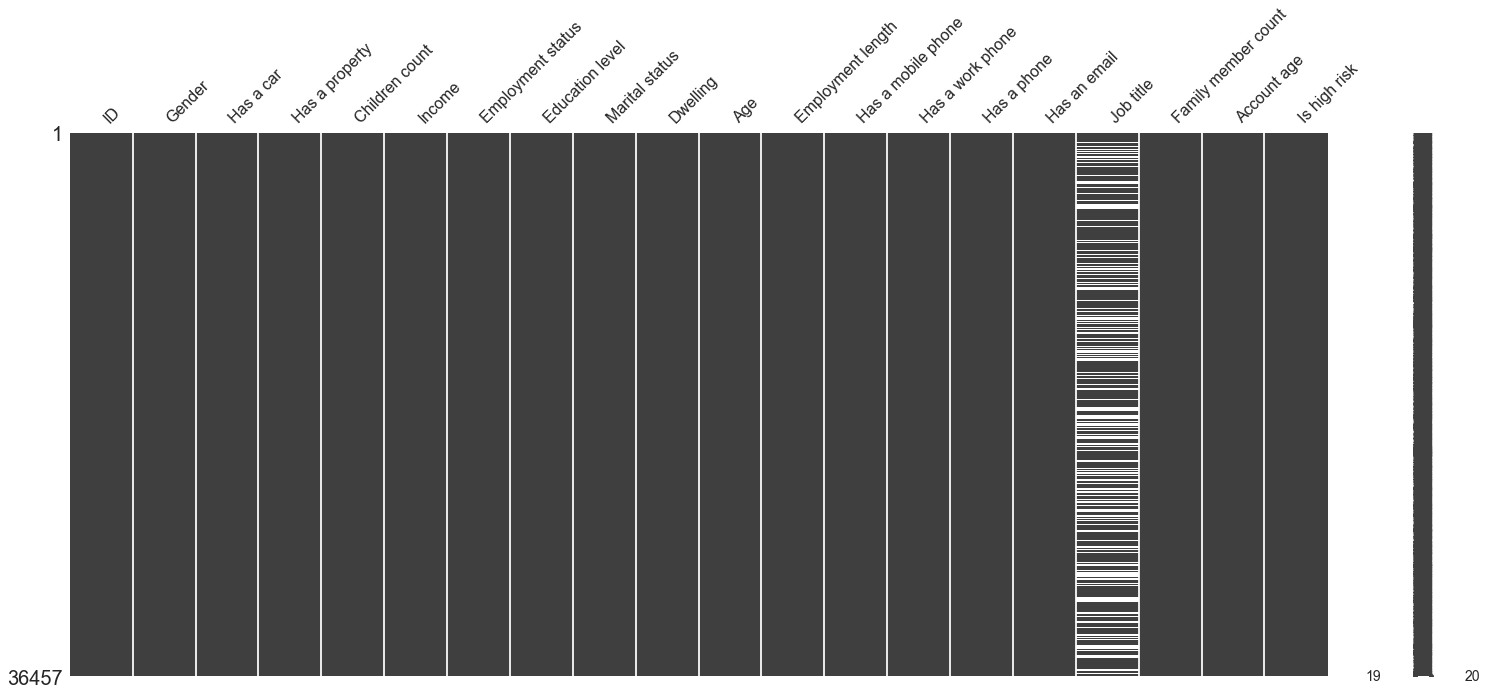

In [41]:
msno.matrix(cc_data_full_data)
plt.show()

Here we can see that the Job title is the only feature with missing values. Slim white lines represent missing values.

To see a clear representation of the missing values count, we can use its ```bar()``` function to have a barplot with the count of non-null values.

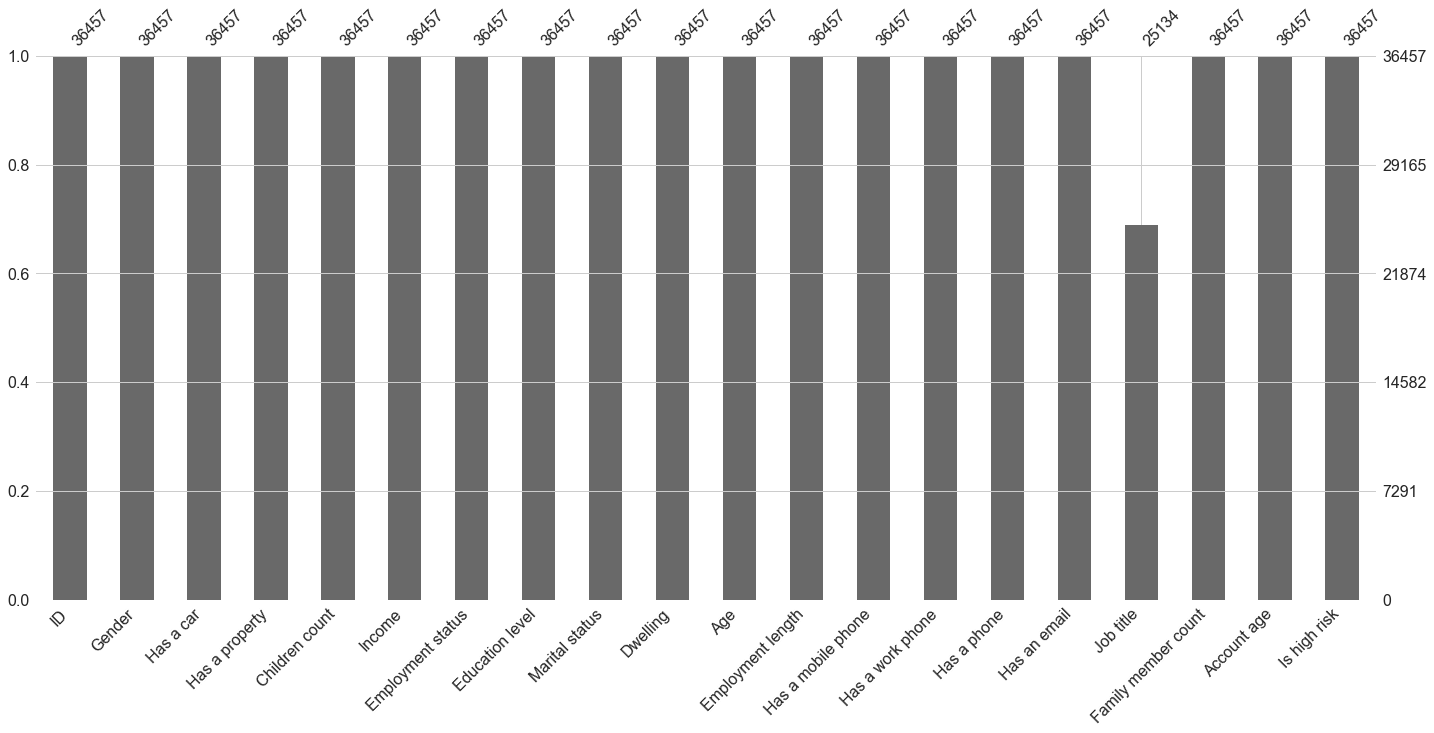

In [42]:
msno.bar(cc_data_full_data)
plt.show()

********** Not grammaly checked **************

Now we will create functions that will be used into analyzing each feature(Univariate analysis). Don't worry too much about understanding these functions as we will see how they will be used during the exploratory data analysis section.

Our first function is ```value_cnt_norm_cal``` which is used to calculate the count of each class in a feature with its frequency (normalized on a scale of 100)

In [48]:
def value_cnt_norm_cal(df,feature):
    '''Function that will return the value count and frequency of each observation within a feature'''
    # get the value counts of each feature
    ftr_value_cnt = df[feature].value_counts()
    # normalize the value counts on a scale of 100
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    # concatenate the value counts with normalized value count column wise
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    # give it a column name
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    #return the dataframe
    return ftr_value_cnt_concat

```gen_info_feat``` returned the description, the datatype, statistics, the value counts and frequencies

Note: I have used the switch statement to handle features differently depending on their data type and characteristics, for example age was divided by 365.25 and changed to a positive values because it was expressed in days instead of years. Same as employment length however we did not print the value count for account age.

In [54]:
def gen_info_feat(df,feature):
    '''function to display general information about the feature'''
    match feature:
        # if the feature is Age
        case 'Age':
            # change the feature to be express in positive numbers days and divide to days by 365.25 to be expressed in years and get the description
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            # print separators
            print('*'*50)
            # print the datatype
            print('Object type:{}'.format(df[feature].dtype))
        # if the feature is employment length
        case 'Employment length':
            # select only the rows where the rows are negative to ignore those who have retired or unemployed
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # change the negative values to positive values
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            # print the descriptions
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            # print separators
            print('*'*50)
            # print the datatype
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        # if the feature is account age
        case 'Account age':
            # change the account age to a positive number of months and get the description
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            # print separators
            print('*'*50)
            # print the datatype
            print('Object type:{}'.format(df[feature].dtype))
        # if it is any other feature
        case _:
            # get the description
            print('Description:\n{}'.format(df[feature].describe()))
            # print separators
            print('*'*50)
            # print the datatype
            print('Object type:\n{}'.format(df[feature].dtype))
            # print separators
            print('*'*50)
            # calling the value_cnt_norm_cal function previously seen
            value_cnt = value_cnt_norm_cal(df,feature)
            #print the result
            print('Value count:\n{}'.format(value_cnt))


The following function print a pie chart.

In [55]:
def create_pie_plot(df,feature):
    '''function to create a pie chart plot'''
    match feature:
        # if the feature is dwelling or education level
        case 'Dwelling' | 'Education level':
            # calling the value_cnt_norm_cal function previously seen
            ratio_size = value_cnt_norm_cal(df, feature)
            # get how many classes do we have
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            # loop till the max range
            for i in range(ratio_size_len):
                #append the ration of each feature to the list
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            #create a subplot
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            # add a title to the chart
            plt.title('Pie chart of {}'.format(feature))
            # add a legend to the chart
            plt.legend(loc='best',labels=ratio_size.index)
            # center the plot in the subplot
            plt.axis('equal')
            # return the plot
            return plt.show()
        # for other features
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

The next function create a barplot

In [ ]:
def create_bar_plot(df,feature):
    '''function to create a bar chart plot'''
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize=(6,10))
            # create a barplot using seabor with X axis the indexes from value_cnt_norm_cal function and Y axis we use the value counts from the same function
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            # set the plot's tick labels to the index from value_cnt_norm_cal function, rotate those ticks by 45 degrees
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            # Give the X axis the same label as the feature name
            plt.xlabel('{}'.format(feature))
            # Give the Y axis the label "Count"
            plt.ylabel('Count')
            # Give the plot a title
            plt.title('{} count'.format(feature))
            # Return the title
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

This function will create a box plot for continues variables


Note: Depending on which transformation need to be done on each feature, we have used a switch statement to handle the different feature that requires different handling.

In [ ]:
def create_box_plot(df,feature):
    '''function to create a box plot'''
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(2,8))
            # change the feature to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # use the numpy arange to populate the Y ticks starting from 0, till the max count of children with interval of 1 as follow np.arange(start, stop, step)
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # employment length in days is a negative number so we need to change it to positive and change it to years
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            # create a boxplot with seaborn
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress the scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

This function will plot a histogram.

In [62]:
def create_hist_plot(df,feature, the_bins=50):
    '''function to create a histogram plot'''
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length':
            employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

This function will plot two box plots, one is for low risk(good client) and the other is for high risk(bad client) applicants. On the Y axis, we have the continuous features we are studying. Again don't worry too much as we will see these functions in action in sections below.

Is high risk
0    7.290112
1    5.750701
Name: Employment length, dtype: float64


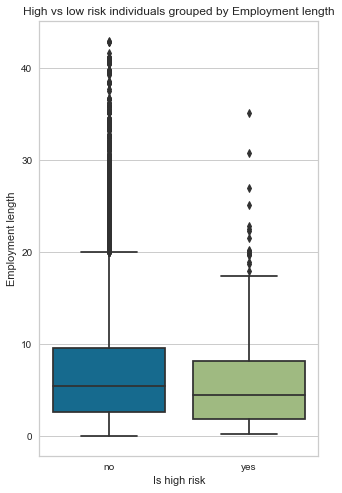

In [68]:
low_high_risk_box_plot(cc_train_copy,'Employment length')

In [67]:
def low_high_risk_box_plot(df,feature):
    '''High risk vs low risk applicants compared on a box plot'''
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            # Place on the Y axis age and X axis the two box plot (is high risk: No and Yes)
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            # add ticks to the X axis
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress the scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length':
            #checking is an applicant is high risk or not (for those who have negative employment length mean only those who employed)
            employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            #extract those who are employed from the original dataframe and return only the employment length and Is high risk columns
            employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            #return the mean employment length group by how risky is the applicant
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

This function is similar to the previous one, the only difference is that it uses a bar plot which is a count of classes for comparison purposes between high risk and low risk

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


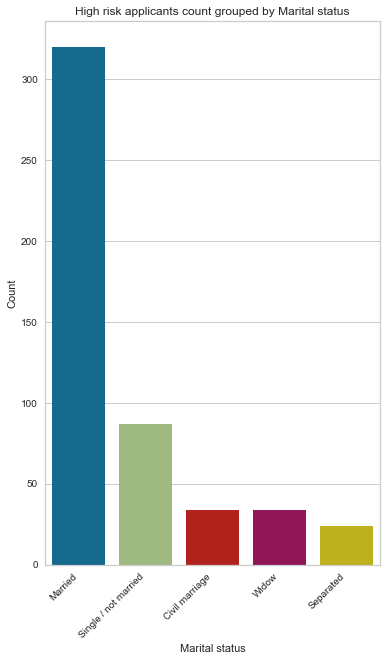

In [70]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

In [71]:
def low_high_risk_bar_plot(df,feature):
    '''High risk vs low risk applicants compared on a bar plot'''
    # get the sum of high risk client grouped by a specific feature
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    # sort is a descending order
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    # plot on the X axis the indexes which correspond to classes and on the Y axis the count
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    # add the labels to the plot
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

Now let's properly start our exploratory data analysis with univariate analysis. Univariate analysis is an analysis of each feature individually in the dataset.

### Univariate analysis

### Gender

We start with the ```Gender```, we get the name information about the gender. We can see that we have two unique values ```F``` (for female) and ```M``` (for male) with 19549 and 9616 occurrences respectively. We can also see that this counts represent 67.02% for ```F``` and 32.97% for ```M```.

In [ ]:
gen_info_feat(cc_train_copy,'Gender')

In [ ]:
create_bar_plot(cc_train_copy,'Gender')

In [ ]:
create_pie_plot(cc_train_copy,'Gender')

### Age

Now let's look at ```Age```, since age is a continous feature we will process it differently than ```Gender```. We first start by looking at the mean, standard deviation minimum, maximum and interquartile range. Then we plot those information on a box plot by calling ```create_box_plot``` function. With that, we can see that the youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)

In [60]:
gen_info_feat(cc_train_copy,'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64


In [61]:
create_box_plot(cc_train_copy,'Age')

NameError: name 'create_box_plot' is not defined

After that, we plot its histogram with the kernel density estimator. Age feature is not normally distributed, it is slightly positively skewed.

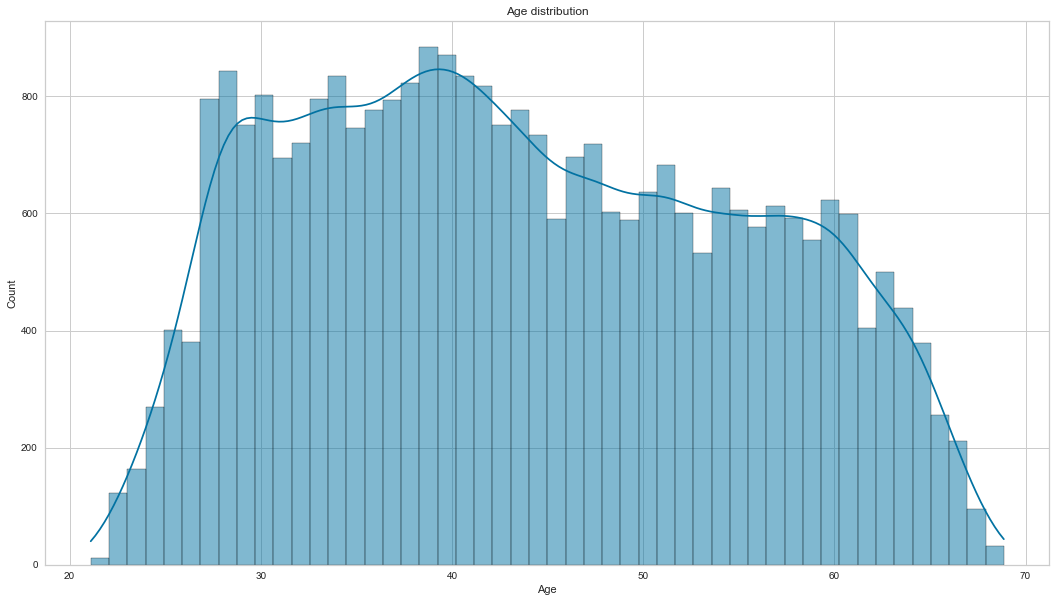

In [63]:
create_hist_plot(cc_train_copy,'Age')

Now we perform a quick bivariate analysis of ```Age``` and the target variable ```Is high risk```. The blue box plot represents good client(is high risk = No) and the green box plot represents bad client(is high risk = Yes). We can see that there is no significant difference between the age of those who are high risk and those who are not. It seems like the median age for both groups is around 43 years old. This mean that there is no correlation between the age and the class in the target variable.

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


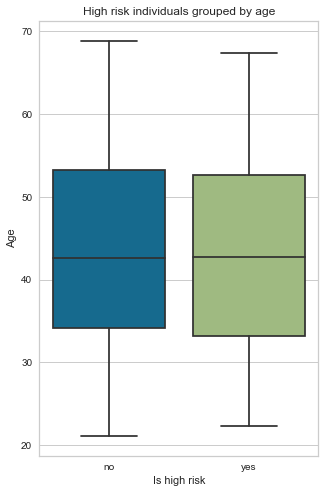

In [66]:
low_high_risk_box_plot(cc_train_copy,'Age')

### Marital status

The information that we gather from ```Marital status``` is that there are 5 unique classes for this feature. Married constitutes the largest proportion of marital status with 68% far ahead from Single. This is clearly seen on the pie and bar chart. Another interesting observation is that even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated by a small margin.

In [ ]:
gen_info_feat(cc_train_copy,'Marital status')

In [ ]:
create_pie_plot(cc_train_copy,'Marital status')

In [ ]:
create_bar_plot(cc_train_copy,'Marital status')

In [ ]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

### Family member count

Family member count is numerical, with the median of 2 family member which equals to 53% of all the counts follow by a single family member with 19% of all the counts. We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household
. wow!

In [ ]:
gen_info_feat(cc_train_copy,'Family member count')

In [ ]:
create_box_plot(cc_train_copy,'Family member count')

In [ ]:
create_bar_plot(cc_train_copy,'Family member count')

### Children count

From the chart below, we can clearly see that most applicants don't have children hence most of them are a couple. Again, we also have 6 outliers, probably the same seen from the family member count


In [ ]:
gen_info_feat(cc_train_copy,'Children count')

In [ ]:
create_box_plot(cc_train_copy,'Children count')

In [ ]:
create_bar_plot(cc_train_copy,'Children count')

### Dwelling type

Most applicant live in houses/apartments by a very large margin.

In [ ]:
gen_info_feat(cc_train_copy,'Dwelling')

In [ ]:
create_pie_plot(cc_train_copy,'Dwelling')

In [ ]:
create_bar_plot(cc_train_copy,'Dwelling')

### Income

Looking at the description, we can see that the average income is 186890 but this amount factors in outliers(mean). If we ignore the outlier most people make 157500 (median). We have 3 applicants who makes more than 1000000.

This feature is also positively skewed. Now focusing on the two box plot, the high risk and low risk applicants have roughly similar income.


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy,'Income')

In [ ]:
create_box_plot(cc_train_copy,'Income')

In [ ]:
create_hist_plot(cc_train_copy,'Income')

* bivariate analysis with target variable

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Income')

### Job title

The most common Job title is laborers by far, followed by core staff, sales staff and managers. We have 30.95% of missing data.

In [ ]:
gen_info_feat(cc_train_copy,'Job title')

In [ ]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
job_title_nan_count

In [ ]:
rows_total_count = cc_train_copy.shape[0]

In [ ]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

In [ ]:
create_bar_plot(cc_train_copy,'Job title')

### Employment status

More than half of applicants are working (51.62%), next most represented status is commercial associate followed by pensioner.

In [ ]:
gen_info_feat(cc_train_copy,'Employment status')

In [ ]:
create_bar_plot(cc_train_copy,'Employment status')

In [ ]:
create_pie_plot(cc_train_copy,'Employment status')

### Education level

The majority of applicants have completed their secondary degree, ¼ completed their higher education.


In [ ]:
gen_info_feat(cc_train_copy,'Education level')

In [ ]:
create_pie_plot(cc_train_copy,'Education level')

In [ ]:
create_bar_plot(cc_train_copy,'Education level')

### Employment length

Most of applicant have been working between 5 to 7 years on average. We also have quite a number of outliers who have been working for more than 20 years+. The employment length histogram is positively skewed. Finally, those who are high risk have a low employment length of 5 versus 7 years for the low risk.


In [ ]:
Most of applicants have a me

In [ ]:
gen_info_feat(cc_train_copy,'Employment length')

In [ ]:
create_box_plot(cc_train_copy,'Employment length')

In [ ]:
create_hist_plot(cc_train_copy,'Employment length')

* bivariate analysis with target variable

In [ ]:
# distribution of employment length for high vs low risk applicants
# Here 0 means No and 1 means Yes
low_high_risk_box_plot(cc_train_copy,'Employment length')

### Has a car

Most applicants don't own a car (62% of applicants).

In [ ]:
gen_info_feat(cc_train_copy,'Has a car')

In [ ]:
create_bar_plot(cc_train_copy,'Has a car')

In [ ]:
create_pie_plot(cc_train_copy,'Has a car')

### Has a property

Most applicants own a property (67% of applicants)

In [ ]:
gen_info_feat(cc_train_copy,'Has a property')

In [ ]:
create_bar_plot(cc_train_copy,'Has a property')

In [ ]:
create_pie_plot(cc_train_copy,'Has a property')

### Has a work phone

More than ¾ of applicants don’t have a work phone

Note: Here 0 represent no and 1 represent yes


In [ ]:
gen_info_feat(cc_train_copy,'Has a work phone')

In [ ]:
create_bar_plot(cc_train_copy,'Has a work phone')

In [ ]:
create_pie_plot(cc_train_copy,'Has a work phone')

### Has a mobile phone

All the applicants without exception have a mobile phone.

Note: Here 0 is no and 1 is yes


In [ ]:
gen_info_feat(cc_train_copy,'Has a mobile phone')

In [ ]:
create_pie_plot(cc_train_copy,'Has a mobile phone')

### Has a phone

Most applicants don’t have a phone(probably a home phone)

Note: Here 0 is no and 1 is yes


In [ ]:
gen_info_feat(cc_train_copy,'Has a phone')

In [ ]:
create_bar_plot(cc_train_copy,'Has a phone')

In [ ]:
create_pie_plot(cc_train_copy,'Has a phone')

### Has an email

More than 90 % of applicants don’t have an email

Note: Here 0 is no and 1 is yes


In [ ]:
gen_info_feat(cc_train_copy,'Has an email')

In [ ]:
create_bar_plot(cc_train_copy,'Has an email')

In [ ]:
create_pie_plot(cc_train_copy,'Has an email')

### Account age

Most accounts are 26 months old. The account age feature is not normally distributed, it is positively skewed. Another observation is that the accounts that have been flagged as high risk are on average 34 months old vs 26 months old for low risk.


In [ ]:
gen_info_feat(cc_train_copy,'Account age')

In [ ]:
create_box_plot(cc_train_copy,'Account age')

In [ ]:
create_hist_plot(cc_train_copy,'Account age', the_bins=30)

* bivariate analysis with target variable

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Account age')

### Is high risk (target variable)

A vast majority of applicants are low risk applicants. We have an imbalance data that needs to be balanced before training on a model.

Note: Here 0 is no and 1 is yes


In [ ]:
gen_info_feat(cc_train_copy,'Is high risk')

In [ ]:
create_bar_plot(cc_train_copy,'Is high risk')

In [ ]:
create_pie_plot(cc_train_copy,'Is high risk')

### Bivariate analysis

Now that we have finished our univariate analysis, we will look into the bivariate analysis. First let's do a bivariate analysis for numerical features using scatter plots.

Looking at the pairplot (scatter plots of all the numerical features), we can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem (two features are highly correlated). We will need to drop one of them.

Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

In [ ]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

Now let's look at interesting scatter plots, we will start with Family member count vs children count. Of course, the more children a person has, the larger the family count.

In [ ]:
sns.regplot(x='Children count',y='Family member count',data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

When comparing account age and applicant age, we can see that most applicants are between 20 and 45 years old and have an account that is less than 25 months old. This information is deduced from the fact that we have darker blue hexagon (which means that we have a high density area) between 20 and 25 on the Y axis and between 5 and 25 on the X axis.


In [ ]:
y_age = np.abs(cc_train_copy['Age'])/365.25
sns.jointplot(np.abs(cc_train_copy['Account age']),y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

Now comparing the employment length and age, the scatterplot shows that the age of the applicants is correlated with the length of the employment. The reason why it is shaped like a reversed triangle, it is because the age of the applicants increase with the length of the employment. You can't have an employment length that is superior than the age.


In [ ]:
x_employ_length = np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x_employ_length,y_age,alpha=.05)
# change the frequency of the x-axis and y-axis labels
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

### Heatmap

Time to do a correlation between all the numerical features using a heatmap. There is no feature that is correlated with the target feature (Is high risk). We see that family member count is highly correlated with children count as previously discussed (The more the children a person has, the larger the family count). Age has some positive correlation with the family member count and children count. The older a person is , the most likely he/she will have a larger family.

Another positive correlation is having a phone and having a work phone. The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone. We also have a negative correlation between the employment length and the age as previously discussed.


In [ ]:
# change the datatype of target feature to int
is_high_risk_int = cc_train_copy['Is high risk'].astype('int32')

In [ ]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile = pd.concat([cc_train_copy.drop(['Has a mobile phone','Is high risk'], axis=1),is_high_risk_int],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

### ANOVA

Now, let's do an ANOVA analysis between age and other categorical categories. Female applicants are older than their male counterpart. Those who don't own a car tend to be older and those who own a property tend to be older than those who don't. Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).

It is also interesting to see that those who hold an academic degree are younger in general than the other groups. The widows tend to be much older. We also see widows outliers in their 30's as well. With no surprise, those who live with parent tend to be younger. We also see some outlier as well here. Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.


In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

Now let's turn our attention to employment length versus categorical features. State employed and medical staff applicant tend to have been employed longer than the rest.


In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

### Applicant general profile

After analyzing each feature, we can create a profile of the average credit card applicant. Here is the profile:

- ***Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.***
- ***Age and income do not have any effects on the target variable***
- ***Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.***
- ***Most applicants are 20 to 45 years old and have an account that is 25 months old or less.***

### 3. Prepare the data

Using the analysis for EDA, here is a list of all the transformations that need to be done on each feature:

ID:
* Drop the feature

Gender:
* One hot encoding

Age:
* Min-max scaling
* Fix skewness
* Abs value and div 365.25

Marital status:
* One hot encoding

Family member count
* Fix outliers

Children count
* Fix outliers
* Drop feature

Dwelling type
* One hot encoding

Income
* Remove outliers
* Fix skewness
* Min-max scaling

Job title
* One hot encoding
* Impute missing values

Employment status:
* One hot encoding

Education level:
* Ordinal encoding

Employment length:
* Remove outliers
* Min-max scaling
* Abs value and div 365.25
* change days of employments of retirees to 0

Has a car:
* Change it numerical
* One-hot encoding

Has a property:
* Change it numerical
* One-hot encoding

Has a mobile phone:
* Drop feature

Has a work phone:
* One-hot encoding

Has a phone:
* One-hot encoding

Has an email:
* One-hot encoding

Account age:
* Drop feature

Is high risk(Target):
* Change the data type to numerical
* balance the data with SMOTE

### Data Cleaning

Here we are creating a class that will be used to handle outliers. This class will remove outliers that are more than 3 inter-quantile range (IQR) away from the mean. This class will be the first class in the scikit-learn ```Pipeline```.

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Feature selection

Next if feature selection, here we are going to drop the features that we judge not to be useful in our prediction. Note this is not a feature selection based on the model coefficients or feauture importance, it is based on basic logic.

The list of features that will be dropped are ID, has a mobile phone, children count, job title, account age.

Now the next question is why are we dropping these features?

- ID: ID is not useful for prediction, it helped us when we were merging the two datasets but after that, there is no need to keep it.
- Has a mobile phone: Since everyone has a mobile phone, this feature does not inform us about anything.
- Children count: is highly correlated with Family member count, and to avoid multicollinearity, we drop it.
- Job title: Has some missing values and the count of each category is not very different to justify the use of mode. So we drop it.
- Account age: Because account was used to create the target, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.


In [ ]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Feature engineering

This class will convert the days to absolute value because we can't have negative days of employments.

In [ ]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

This other class will convert the employment length of retirees (set to 365243) to 0 so that it is not considered as an outlier.

In [ ]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

This class will reduce the skewness of income and age using the cubic root transformation. Skewed features tend not to affect the performance of our predictive model. 

In [ ]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

This class with change 1 to the character "Y" and 0 to "N" which will be easier when we are doing a one-hot encoding.

In [ ]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

This class will do a one hot encoding on the categorical features, the difference is that this class will also keep the features names as well. The reason why we want to keep the features names instead of an array is because these features name will be used into coming up with the feature importance.

In [ ]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

This class will convert the education level to an ordinal encoding. Here we are using ordinal encoding instead of one hot encoding because we know that the education level are ranked (University is higher than primary school).

In [ ]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

This class will scale the feature using min-max scaling while keeping the feature names as well.

In [ ]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

This class will change the data type of the target variable to numerical.

In [ ]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

This class will oversample the target variable using SMOTE because the minority class (Is high risk = 1) is very rare in the data as we have seen it while doing EDA of the target variable (It only accounts for about 1.71% of the total data).

In [ ]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

### Data Preprocessing

Now we are ready to create the data preprocessing pipeline using the built sklearn function ```Pipeline```. What this function does is to call each class in the pipeline sequentially starting from the outlier remover to oversample class. The dataset will be transform sequentially from one class to the next one. The pipeline will be stored in a variable called pipeline and will call ```fit_transform``` on that variable, pass in our dataframe we want to transform and return the result.

In [ ]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

Now we pass in the train dataset

In [ ]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
cc_train_prep = full_pipeline(cc_train_copy)

We check how many rows and columns we have after the transformation.

In [ ]:
cc_train_prep.shape

Have a quick look at the first few rows of the transformed dataframe. We can see that the column's names have been kept.

In [ ]:
pd.set_option('display.max_columns', None)
cc_train_prep.head()

Now, we extract the target variable ```Is high risk``` from the dataframe and create a new dataframe composed of independent features with a series of the target variable.

In [ ]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

### Short-list promising models

Alright! the moment you have been waiting for has finally arrived, time to train our models. We first create a dictionary of models and their corresponding names. This dictionary will be used to loop through all the models and train them without having to write them over and over again.

In [ ]:
classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'support_vector_machine':SVC(random_state=42,probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

Now we will write some of the functions that will be used into training our model. The first function is a function to plot the feature importance of the model. The feature importance is a set of features that do contribute more(or less) than other features to the model prediction

In [ ]:
# Function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

This function on the other hand, is used to get the y prediction of the model using cross validation prediction with k fold equal to 10.

In [ ]:
# Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            # if it exist load the predictions
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if it exist load the predictions
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

This function will plot the confusion matrix for each of the algorithms.

In [ ]:
# Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')

The next function will plot the ROC curve of each model.

In [ ]:
# Function to plot the roc curve
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y probabilities file exists, if not create it
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba,y_proba_path)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        # check if y probabilities file exists, if not create it
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final,y_proba_path_final)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')

This other function will print the classification report. A classification report is a table that describes the performance of a classification model and has information like precision, recall, f1-score, support, accuracy.

In [ ]:
# Function to display the classification report
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

This function will train the model and save it in the ```saved_models``` and ```saved_models_final``` folder


In [ ]:
# Function to train the model
def train_model(model,model_name,final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exist and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exist and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn

Now we will look at the ```folder_check_model``` which will check if ```saved_models``` folder exists, if not it will create it.

In [ ]:
def folder_check_model():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))

Lastly, we create a for loop function that will loop through the dictionary of models and call all the functions above.

In [ ]:
# loop over all the models
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)
    warnings.filterwarnings("ignore")


### What metrics to use for this problem?

Since the objective of this problem is to minimize the risk of credit default for the financial institution, the metrics to use depends on the current economical situation:

- During the time of a bull market (when the economy is expending), people feel wealthy and usually are employed. Money is usually cheap and the risk of default is low. The financial institution is able to handle the risk of default therefore is not very strict on giving out credit. The financial institution can handle a number of bad clients as long as the vast majority of applicants are good clients (aka those who payback their credit).In this case, having a good recall (sensitivity) is ideal.
- During a bear market (when the economy is contracting), people loose their jobs and their money through the stock market. Many people struggle to meet their financial obligations. The financial institution therefore tend to be more conservative on giving out credit or loans. The financial institution can't afford to give out credit to clients who won't be able to pay back their credit. The financial institution would rather have a smaller number of good clients even if it means that some good clients where denied credit, and ideally not have any bad client. In this case, having a good precision (specificity) is desirable.

Note: There is always a trade-off between precision and recall. Choosing the right metrics depends on the problem you are solving.

Conclusion: In our case, since we are in the longest bull market (not including the March 2020 flash crash), we will use recall as our metric.

### Top model

Using the ROC curve and recall, we can that conclude that the best model is:
- Gradient boosting classifier

Now the question that might be asked is how did we choose gradient boosting as the best model?

Let's look at the picture below

![heatmap](../assets/post_cont_image/roc_curve.svg)

Source: [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:Roc_curve.svg)

With this ROC curve, we can compare the perfomance of different classifiers. The closer the curve is to the top left corner without actually reaching the far end of the corner, the better the model

- Any classifier's ROC below the dashed red line is performing worst than random chance. Random chance is 50% chance of being correct for a binary classifier.
- Any classifier with the ROC curve blended with the dashed red line is no better than tossing a fair coin.
- The orange curve is slightly better than dashed red line but that would not be considered a good classifier.
- The green curve is much better than the orange one but could be better.
- Now the blue curve is the best classifier, this curve gets closer to the top left without actually touching the top left corner.
- Lastly the "perfect" curve that actually touches the top left corner is not a good classifier. You might asked why, well it is because a classifier with this curve is overfitting meaning that it has learn so well on the training data but can't generalize well on the test data.

So what to do when a classifier is overfitting? Well these are the options to deal with this issue:
- Use a simplified model by selecting fewer parameters or constraining the model (also called regularization).
- Gather more training data.
- Discard outliers and fix missing data.

### Test the final model on the test set

Now that we have our model trained, we can use it to predict the classes on the test set.

In [ ]:
cc_test_copy.head(5)

We pass to the scikit-learn pipeline, the test set as we did for the training set to obtain a preprocessed dataset ready for our model.

In [ ]:
cc_test_prep = full_pipeline(cc_test_copy)

We extract the independent variables/features and the target variable and store them into variables ```X_cc_test_prep``` and ```y_cc_test_prep``` respectively.

In [ ]:
# split the train data into X and y (target)
X_cc_test_prep, y_cc_test_prep = cc_test_prep.loc[:, cc_test_prep.columns != 'Is high risk'], cc_test_prep['Is high risk'].astype('int64')

Next, we train the model

In [ ]:
# train the model
model_trn = train_model(classifiers['gradient_boosting'],'gradient_boosting')

Then make prediction on the independent variables, we store the prediction in ```final_prediction``` variable.

In [ ]:
final_predictions = model_trn.predict(X_cc_test_prep)

Now we use the ```shape``` method to get the number of rows we have to see if they correspond to the number of rows in the test dataset.

In [ ]:
final_predictions.shape

We use the ```sum``` function to compare the prediction that were correct and those that were not. We store the count of the correct predictions in ```n_correct```

In [ ]:
n_correct = sum(final_predictions == y_cc_test_prep)

We divide the number of correct predictions by the total number of predictions to get the accuracy. We acheive a 85% accuracy on the testing set which is very good!

In [ ]:
print(n_correct/len(final_predictions))

### Deploying the model on AWS S3 bucket

Now we will deploy the saved trained model to AWS S3, but what is AWS S3 bucket you may ask?

AWS S3(which stands for Simple Storage Service) is a cloud storage service that provides access to the storage of data in the cloud. the object stored can be accessed through secret access keys. In our case, we will access the predictions from our model using the secret access key.

Now, let's store the model on AWS S3. You will need first to create an AWS account.